<a href="https://colab.research.google.com/github/ovictormiranda/COMPUTER_VISION_SOCCER/blob/main/MVP_Computer_vision_PUCRIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP - Visão Computacional aplicada ao Futebol**


## **Introdução**
O futebol tem se beneficiado do avanço tecnológico, especialmente na análise de dados que potencializa estratégias. Grandes quantidades de dados são coletadas de ligas e campeonatos por players como a SofaScore, WyScout e InStat. No entanto, a coleta geralmente é feita manualmente por analistas de jogos que marcam ações dos jogadores em campo durante as partidas. Embora esses dados alimentem estatísticas interessantes, eles são genéricos e não tão específicos para os clubes. Clubes também realizam suas próprias coletas de dados, muitas vezes usando dispositivos GPS em cada jogador, mas esses dados são limitados ao próprio clube.

A visão computacional desempenha um papel fundamental na tomada de decisões e no desenvolvimento de estratégias no futebol. Antes e durante o jogo, os treinadores, especialmente os adeptos da escola europeia, contam com equipes de analistas de desempenho e estratégia. Esses profissionais se dedicam a analisar os pontos fortes e vulnerabilidades do adversário, bem como a melhorar o desempenho de sua própria equipe, muitas vezes focando em aspectos específicos como jogadas de bola parada. No entanto, esse processo consome horas de revisão de jogos para extrair insights e preparar relatórios para os treinadores, visando planejar estratégias vencedoras para o próximo jogo.

A aplicação da visão computacional nesse contexto pode otimizar significativamente esse processo. Além do rastreamento de jogadores e da análise de estatísticas como distâncias percorridas e velocidade, a visão computacional pode ser utilizada para detectar espaços entre linhas e na profundidade, tanto em situações de ataque quanto de defesa. Além disso, permite mapear o posicionamento dos jogadores de acordo com as estratégias definidas, garantindo que a equipe esteja alinhada com o plano tático traçado. No futebol posicional, onde a ocupação correta de espaços é fundamental, essa capacidade de monitoramento e análise é de extrema importância para o sucesso da equipe.

Considerando esses aspectos, decidi criar um MVP focado na detecção e rastreamento de elementos-chave do jogo, como a bola, jogadores, goleiros e a equipe de arbitragem. Além disso, o sistema será capaz de identificar as equipes com base na cor das camisas dos jogadores.

##**Fonte de dados**
O dataset foi adquirido no Roboflow e consiste em imagens de transmissões televisivas de partidas de futebol, totalizando 663 imagens.
https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/1

**Características:**

* 663 imagens disponíveis.
* Imagens capturadas durante transmissões televisivas de jogos de futebol.
* Alta variedade de cenários e situações de jogo.
* Desafios incluem desbalanceamento na quantidade de jogadores, goleiros, equipe de arbitragem e a bola, além de amplo plano de fundo nas imagens.

**Objetivo:**

O dataset tem como objetivo fornecer uma base para o treinamento e validação de modelos de detecção de jogadores de futebol. Ele será utilizado como parte do processo de finetuning do modelo YOLO (You Only Look Once), visando adaptar o modelo às características específicas das imagens de jogos de futebol.

Na pasta 'input_videos', utilizei um vídeo retirado de um dataset disponível no Kaggle. Como o objetivo principal do projeto é a análise de partidas de futebol em vídeo, optei por selecionar este vídeo para simular o funcionamento prático do MVP.

Você pode acessar o dataset completo através do seguinte link: https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data


# **1. Preparação do Ambiente**

Antes de iniciarmos, é necessário instalar as dependências necessárias para o projeto. Para isso, precisaremos das bibliotecas Ultralytics, Roboflow, OpenCV-Python e Supervision.

In [1]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python
!pip install supervision


Após a conclusão das instalações, estamos prontos para importar as bibliotecas necessárias para o projeto.

In [2]:
import os
from google.colab import drive
import shutil

from ultralytics import YOLO
from roboflow import Roboflow
import supervision as sv
import cv2

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

Vamos manipular alguns dados que estão armazenados neste drive, então precisaremos montá-lo para termos acesso ao Google Drive.

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Agora que temos acesso aos Google Drive, vamos criar uma estrutura de pastas pro nosso projeto.
Essas serão as principais pastas do nosso projeto, e podemos dizer que a pasta raiz é a soccer_analysis.

**soccer_analysis**

    input_videos
    models
    output_videos
    runs
    stubs
    training

Essa é a estrutura de pastas completa do nosso projeto.

**soccer_analysis**

    input_videos

    models

    output_videos
    
    runs
        detect
            train
                weights
            train2
                weights
        predict
    
    stubs
    
    training
        football-players-detection-1
            football-players-detection-1
                test
                    images
                    labels
                train
                    images
                    labels
                valid
                    images
                    labels



Para facilitar, vamos preparar previamente as pastas que receberão as informações. Além disso, armazenaremos o caminho do diretório raiz para facilitar o acesso aos arquivos. Isso é importante para evitar a repetição desse caminho toda vez que acessarmos algum arquivo no Google Drive, o que nos ajudará a navegar pelas pastas do projeto.

In [6]:
ROOT_DIR = '/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis'

In [ ]:

#Definindo o 'endereço' dos paths
'''
models_path = (ROOT_DIR + '/models')
output_videos_path = (ROOT_DIR + '/output_videos_path')
runs_path = (ROOT_DIR + '/runs')
detect_path = (runs_path + '/detect')
stubs_path = (ROOT_DIR + '/stubs')
training_path = (ROOT_DIR + '/training')
trained_path = (training_path + '/football-players-detection-1')
'''

#Criando os paths
'''
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_videos_path, exist_ok=True)
os.makedirs(runs_path, exist_ok=True)
os.makedirs(detect_path, exist_ok=True)
os.makedirs(stubs_path, exist_ok=True)
os.makedirs(training_path, exist_ok=True)
os.makedirs(trained_path, exist_ok=True)
'''

O código acima está comentado, porque o projeto já está com as pastas criadas.

#**2. Introdução a YOLO e Processamento de vídeo**


Um dos algoritmos mais populares e eficazes para detecção de objetos em tempo real é o YOLO (You Only Look Once).

Utilza uma abordagem de detecção de objetos baseada em redes neurais convolucionais (CNNs). O que o torna único é que ele aborda o problema de detecção de objetos como um problema de regressão de caixa delimitadora, em vez de abordagens baseadas em regiões propostas, como R-CNN. Isso permite que o YOLO seja extremamente rápido, capaz de detectar objetos em tempo real em vídeos e imagens.


In [8]:
model_initial = YOLO('yolov8x')

100%|██████████| 131M/131M [00:00<00:00, 207MB/s]


As funções apresentadas abaixo utilizam o YOLO para realizar tarefas importantes no processamento de vídeo, como detecção de objetos e captura de frames.

* **predict_test:** Esta função utiliza um modelo pré-treinado da YOLO para realizar previsões em um vídeo específico. Seu objetivo é identificar e delimitar objetos de interesse em cada frame do vídeo, fornecendo informações sobre suas coordenadas e classes.

* **capture_frame:** Essa função é responsável por capturar um frame de um vídeo e exibi-lo como uma imagem. Ela permite visualizar o conteúdo de um frame específico para inspeção visual ou análise manual.

In [4]:
# Função para efetuar predição utilizando o modelo pré treinado da YOLO puro
def predict_test(model, video_path):
  results = model.predict(source=video_path, save=True)
  print(results[0])
  print('=====================================')
  for box in results[0].boxes:
    print(box)


# Função para capturar um frame e exibi-lo como uma imagem
def capture_frame(video_path):
    cap = cv2.VideoCapture(video_path)

    # Verificando se o vídeo foi aberto corretamente
    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return

    # Capturar o primeiro frame do vídeo
    ret, frame = cap.read()

    # Verificar se o frame foi capturado corretamente
    if not ret:
        print("Erro ao capturar o frame.")
        return

    # Convertendo o frame para RGB (OpenCV carrega frames em BGR por padrão)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Ajustar o tamanho da figura
    plt.figure(figsize=(12, 10))

    plt.imshow(frame_rgb)
    plt.axis('off')  # Desativar os eixos
    plt.show()

    # Fechar o objeto de captura
    cap.release()

In [9]:
#Caminho do video
video_path = os.path.join(ROOT_DIR, 'input_videos/08fd33_4.mp4')

predict_test(model_initial, video_path)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos/08fd33_4.mp4: 384x640 23 persons, 1 sports ball, 2872.0ms
video 1/1 (frame 2/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos/08fd33_4.mp4: 384x640 23 persons, 1 sports ball, 3009.1ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos/08fd33_4.mp4: 384x640 25 persons, 

No log acima, podemos visualizar as ações do modelo e as detecções que ele realiza a cada frame do vídeo. Os resultados dessa predição são salvos no diretório runs/detect/predict, com o nome do arquivo sendo o mesmo do vídeo. Para garantir o acesso contínuo a essas informações e resultados, é necessário mover os dados para uma pasta sob nosso controle, que será a pasta soccer_analytics/runs/detect/predict.

In [10]:
# Caminho dentro do nosso projeto, para guardarmos o resultado
path_predict_test = os.path.join(ROOT_DIR, 'runs/detect/predict')

# Mover os dados para a pasta
'''
shutil.move('/content/runs/detect', path_predict_test)
'''

"\nshutil.move('/content/runs/detect', path_predict_test)\n"


Você pode acessar o vídeo completo no seguinte caminho: soccer_analytics > runs > predict. No entanto, abaixo, vamos visualizar um frame dele para termos uma ideia do que estamos falando, sem precisar sair desta página.

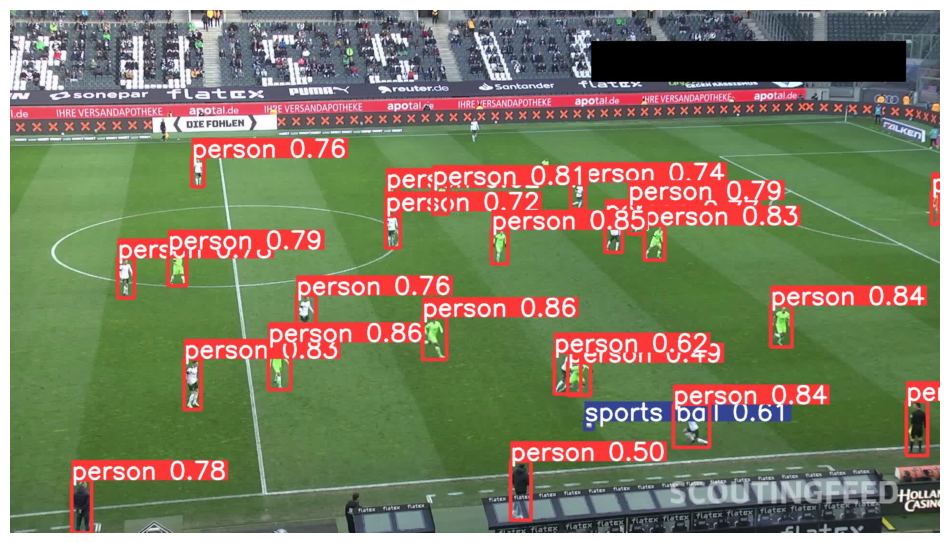

In [11]:
video_test_predict = os.path.join(ROOT_DIR, 'runs/detect/predict/08fd33_4.avi')
capture_frame(video_test_predict)

No registro de predição do modelo, obtemos a seguinte saída:

    ultralytics.engine.results.Results object with attributes:
    boxes: ultralytics.engine.results.Boxes object
    keypoints: None
    masks: None
    names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

As chaves keypoints e masks estão como None porque são utilizadas para pose estimation e segmentação, respectivamente. O dicionário names corresponde às opções de detecção disponíveis pelo modelo YOLO. Para este projeto, estamos interessados apenas em detectar jogadores, árbitros (person) e a bola de futebol (sports ball).

E como exemplo, obtivemos esse resultado de predição:

    cls: tensor([0.], device='cuda:0')
    conf: tensor([0.8493], device='cuda:0')
    data: tensor([[9.9717e+02, 5.2244e+02, 1.0549e+03, 6.7972e+02, 8.4930e-01, 0.0000e+00]], device='cuda:0')
    id: None
    is_track: False
    orig_shape: (1080, 1920)
    shape: torch.Size([1, 6])
    xywh: tensor([[1026.0289,  601.0784,   57.7277,  157.2830]], device='cuda:0')
    xywhn: tensor([[0.5344, 0.5566, 0.0301, 0.1456]], device='cuda:0')
    xyxy: tensor([[ 997.1651,  522.4369, 1054.8928,  679.7199]], device='cuda:0')
    xyxyn: tensor([[0.5194, 0.4837, 0.5494, 0.6294]], device='cuda:0')
    


A detecção de objetos é realizada utilizando bounding boxes, que determinam a localização do objeto dentro da imagem (neste caso, do quadro do vídeo) por meio de coordenadas x e y. Essas coordenadas apontam para o centro do objeto detectado, enquanto o tamanho do objeto é dado pelas dimensões w e h (largura e altura, respectivamente). Uma alternativa é utilizar as coordenadas dos vértices superior esquerdo (top-left) e inferior direito (bottom-right) da bounding box, e é essa estratégia que adotaremos neste projeto (formato xyxy).

É importante destacar a relação entre frames e segundos no vídeo. Um vídeo consiste em uma sequência de imagens, onde várias imagens são exibidas por segundo. Ao detectar um objeto em um vídeo, é necessário identificá-lo em cada um desses frames sucessivos.

Quando id: None e is_Track: False são exibidos em uma predição, isso significa que os objetos não estão recebendo identificadores únicos e também não estão sendo rastreados durante as transições de frames. Cada frame do vídeo é tratado como uma imagem separada, e a detecção precisa ser feita e rastreada em cada uma dessas imagens individualmente.

In [ ]:
# A celula está comentada porque já foi realizada a transferência
'''
shutil.move('/content/runs', ROOT_DIR)
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/runs'

#**3. Fine-tuning**



Para alcançarmos os objetivos deste MVP, nos deparamos com alguns desafios. O modelo genérico do YOLO possui a capacidade de identificar uma ampla variedade de classes, no entanto, para esta aplicação específica, essa generalidade não é ideal.

Ao analisarmos visualmente o vídeo com os bounding boxes projetados, observamos algumas questões que precisam ser abordadas. Em primeiro lugar, notamos que o modelo está identificando pessoas de forma genérica, sem distinguir entre jogadores, árbitros, goleiros. Precisamos que essas 'pessoas' deixem de serem apenas 'pessoas', e recebam suas devidas classes.

Além disso, o modelo está detectando pessoas que estão fora do campo de jogo. Essas detecções são irrelevantes para nossa análise e podem introduzir ruído nos resultados. Portanto, o modelo precisa ser ajustado para ignorar essas detecções fora do campo.

Para superar esses desafios, aplicare,p uma técnica chamada fine-tuning. O fine-tuning envolve ajustar um modelo pré-treinado para se adequar melhor aos requisitos específicos de um problema ou aplicação. Utilizando o dataset da Roboflow, que mencionamos anteriormente e que possui quatro classes:

    Jogador (Player)
    Goleiro (Goalkeeper)
    Bola (Ball)
    Árbitro (Referee)

Ao aplicar o fine-tuning, esperamos melhorar significativamente a capacidade do nosso modelo em diferenciar entre essas classes e, assim, aprimorar a qualidade das análises de vídeos de futebol.

##**3.1 Treinamento**

E para ter acesso a essas dados, precisamos baixa-los utilizando o código abaixo.

In [ ]:
#Codígo gerado pelo Roboflow
rf = Roboflow(api_key="6lXI5l5ZiKgkA6hd1z1P") #esse hash é unico
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(1)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-1 in yolov5pytorch:: 100%|██████████| 1338/1338 [00:00<00:00, 3048.89it/s]


Agora que já foi feito o download, vamos mover os dados para a pasta do projeto.

In [ ]:
# As celulas estão comentadas porque já foi realizada a transferência
'''
shutil.move('/content/football-players-detection-1', (ROOT_DIR + '/training'))
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/training/football-players-detection-1'

O processo de mover pastas entre diretórios no Google Drive pode ser um pouco demorado. Embora o comando seja executado rapidamente, ainda é necessário aguardar o tempo necessário para o Google Drive transferir os arquivos para o novo local. Isso geralmente leva entre 7 e 10 minutos, mas o tempo pode variar dependendo da velocidade da conexão com a internet.


In [ ]:
# As celulas estão comentadas porque já foi realizada a transferência
'''
shutil.move((ROOT_DIR + '/training/football-players-detection-1/train'),
             (ROOT_DIR + 'football-players-detection-1/football-players-detection-1/train'))

shutil.move((ROOT_DIR + '/training/football-players-detection-1/test'),
             (ROOT_DIR + '/training/football-players-detection-1/football-players-detection-1/test'))

shutil.move((ROOT_DIR + '/training/football-players-detection-1/valid'),
             (ROOT_DIR + '/training/football-players-detection-1/football-players-detection-1/valid'))
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/training/football-players-detection-1/football-players-detection-1/valid'

Essa segunda etapa de transferência de pastas entre diretórios é necessária porque o arquivo data.yaml precisa estar em um diretório anterior aos diretórios de treinamento, teste e validação.

Essa linha de código realiza o fine-tuning do modelo YOLO utilizando o dataset baixado do Roboflow. Vamos entender cada um dos parâmetros:

    !yolo: Este é o comando utilizado para iniciar o processo de treinamento com o YOLO.
    task=detect: Define a tarefa que o YOLO deve executar durante o treinamento, que neste caso é a detecção de objetos.
    mode=train: Indica que estamos realizando o treinamento do modelo.
    model=yolov5x.pt: Especifica o modelo pré-treinado que será utilizado como ponto de partida para o fine-tuning. Neste caso, estamos utilizando o modelo YOLO na versão 5x.
    data='/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/training/football-players-detection-1/data.yaml': Define o caminho para o arquivo data.yaml, que contém as informações necessárias para o treinamento, como a localização das pastas contendo as imagens e os rótulos de treinamento, teste e validação.
    epochs=100: Determina o número de épocas que serão utilizadas durante o treinamento, neste caso, são 100 épocas.
    imgsz=640: Especifica o tamanho das imagens que serão utilizadas durante o treinamento, sendo 640x640 pixels.

In [ ]:
!yolo task=detect mode=train model=yolov5x.pt data='/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/training/football-players-detection-1/data.yaml' epochs=100 imgsz=640

PRO TIP 💡 Replace 'model=yolov5x.pt' with new 'model=yolov5xu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

100% 186M/186M [00:00<00:00, 389MB/s]
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov5x.pt, data=/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/training/football-players-detection-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True,

Agora que treinamos o modelo, vamos mover os dados gerados para a pasta do projeto.

In [ ]:
# As celulas estão comentadas porque já foi realizada a transferência
'''
shutil.move('/content/runs/detect/train', (ROOT_DIR + '/runs/detect'))
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/runs/detect/train'

## **3.2 Resultados do modelo**


Ao realizar o treinamento do modelo, além do modelo treinado que discutiremos posteriormente, são gerados alguns dados que fornecem informações sobre o que foi produzido durante essa sessão de treinamento. Para facilitar a visualização e análise desses resultados, vamos criar uma função para plotar imagens aqui no colab.

In [12]:
def plot_image(path_image):
  # Carregar a imagem usando o matplotlib
  image = mpimg.imread(path_image)

  plt.figure(figsize=(12, 10))

  # Exibir a imagem
  plt.imshow(image)
  plt.axis('off')  # Desativar os eixos
  plt.show()

Vamos analisar 3 dessas imagens, começando pela matriz de confusao normalizada.


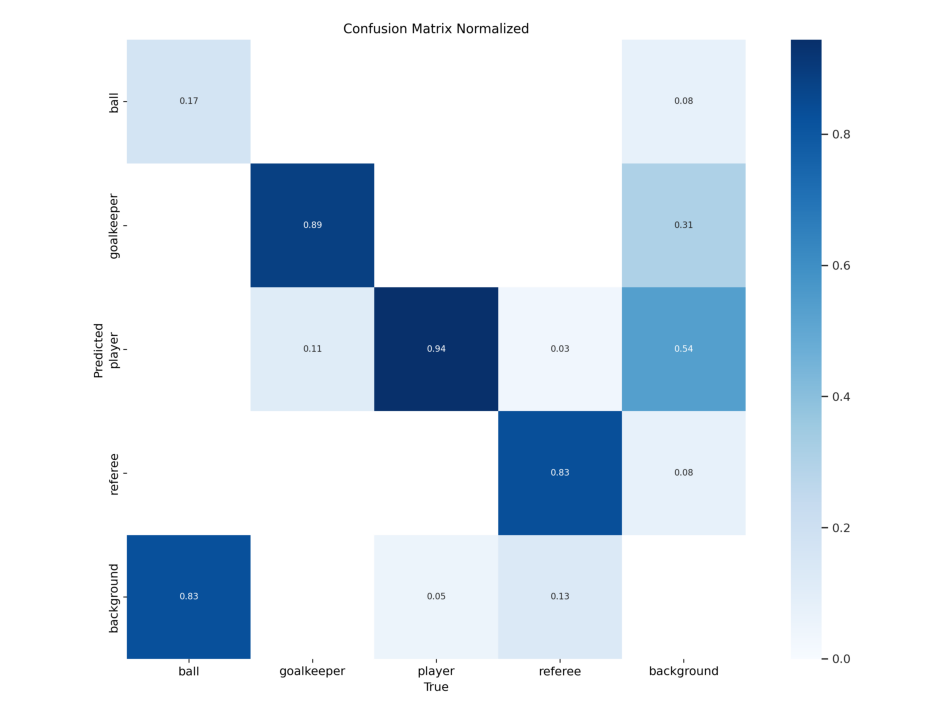

In [13]:
# Definindo path das imagens
path_confusion_matrix_norm = ROOT_DIR + '/runs/detect/train/confusion_matrix_normalized.png'
path_confusion_matrix = ROOT_DIR + '/runs/detect/train/confusion_matrix.png'
path_results = ROOT_DIR + '/runs/detect/train/results.png'

# Plotando as imagens
plot_image(path_confusion_matrix_norm)

Considerando a natureza dos dados, era esperada uma certa dificuldade na detecção da bola. Isso se deve ao fato de termos uma amostragem muito pequena em comparação com os outros objetos, e devido à sua pequena dimensão em relação à imagem como um todo, e faz com que a bola seja facilmente confundida com o backgrounds. No entanto, obtivemos resultados satisfatórios na identificação de goleiros, árbitros e, principalmente, dos jogadores.

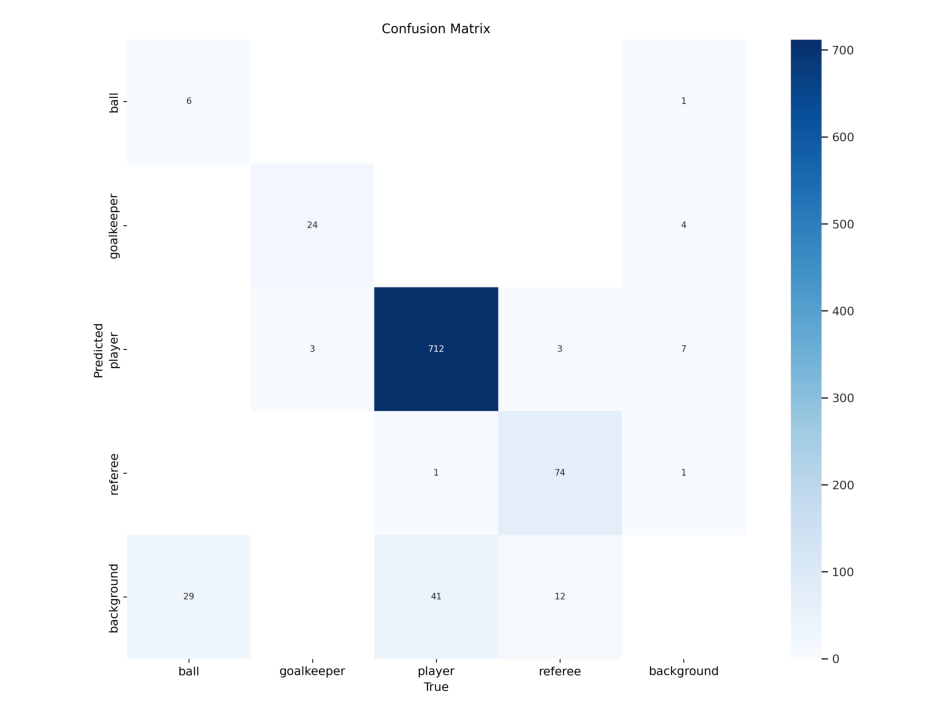

In [14]:
plot_image(path_confusion_matrix)

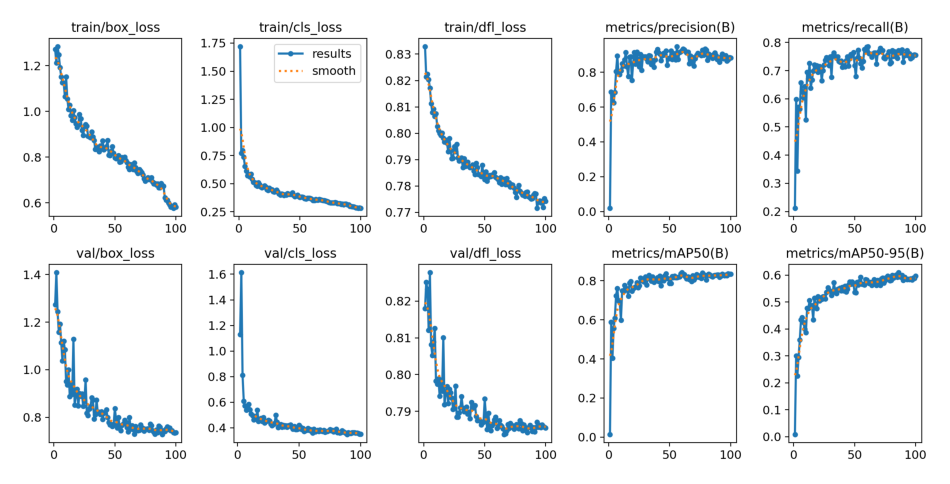

In [15]:
plot_image(path_results)


Ao analisar os gráficos, podemos observar uma tendência positiva em relação à qualidade dos treinamentos ao longo das épocas. As métricas de loss, representadas pelos gráficos de tran/box_loss, train/cls_loss e train/dfl_loss, mostram uma diminuição gradual ao longo das épocas. Inicialmente, essas métricas começam em níveis relativamente altos e diminuem conforme o treinamento avança. Isso indica que o modelo está aprendendo e se ajustando aos dados de treinamento, reduzindo assim as perdas associadas à detecção de caixas delimitadoras, classificação e outras características específicas.

Por outro lado, as métricas de precisão, representadas pelos gráficos de metrics/precision(B), metrics/recall(B), metrics/mAP50(B) e metrics/mAP50-95(B), mostram uma tendência oposta. Essas métricas começam em níveis mais baixos e aumentam à medida que mais épocas são acumuladas durante o treinamento. Isso indica que o modelo está melhorando sua capacidade de precisão na detecção de objetos, aumentando tanto a precisão quanto a revocação e as métricas de Average Precision (mAP). Essa melhoria na precisão ao longo das épocas sugere que o modelo está se tornando mais eficaz na identificação e classificação de objetos, resultando em uma melhor qualidade geral dos treinamentos.

Além dessa informações, também é gerada uma pasta weights que contem o melhor e o ultimo modelo, e que iremos transferir para a pasta models

In [ ]:
# As celulas estão comentadas porque a transferencia já foi realizada
#Definido o caminho dos arquivos a serem copiados
'''
best_model = (ROOT_DIR + '/runs/detect/train/weights/best.pt')
last_model = (ROOT_DIR + '/runs/detect/train/weights/last.pt')
'''
#Copiano e colando
'''
shutil.copy(best_model, models_path) #o models_path foi criado no inicio do projeto
shutil.copy(last_model, models_path)
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/models/last.pt'

## **3.3 Modelo pós fine-tuning**

In [ ]:
#utilizando o modelo treinado
model_tuning = YOLO(ROOT_DIR + '/models/best.pt')

video_path = os.path.join(ROOT_DIR, 'input_videos/08fd33_4.mp4')

predict_test(model_tuning, video_path)




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos/08fd33_4.mp4: 384x640 1 ball, 1 goalkeeper, 18 players, 3 referees, 167.3ms
video 1/1 (frame 2/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos/08fd33_4.mp4: 384x640 1 ball, 1 goalkeeper, 18 players, 3 referees, 15.5ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/input_videos

Como já temos um video desse salvo, vamos renomear o arquivo antes para que o video nao seja sobrescrito.

In [ ]:
# A celula está comentada porque já foi realizada a transferência
# Definir o caminho atual e o novo nome do arquivo
'''
file_to_rename = '/content/runs/detect/predict/08fd33_4.avi'
new_name = '08fd33_4(2).avi'

# Renomear o arquivo
os.rename(file_to_rename, os.path.join(os.path.dirname(file_to_rename), new_name))
'''

Agora, vamos mover para a pasta do projeto.

In [ ]:
# A celula está comentada porque já foi realizada a transferência
'''
shutil.move('/content/runs/detect/predict/08fd33_4(2).avi', (ROOT_DIR + '/runs/detect/predict'))
'''

'/content/gdrive/My Drive/Computer_Vision_Project/soccer_analysis/runs/detect/predict/08fd33_4(2).avi'

Bom, é possível visualizar o video através do caminho:

    soccer_analisys > runs > detect > predict

Mas de todo casa, vamos visualizar um frame desse video por aqui.

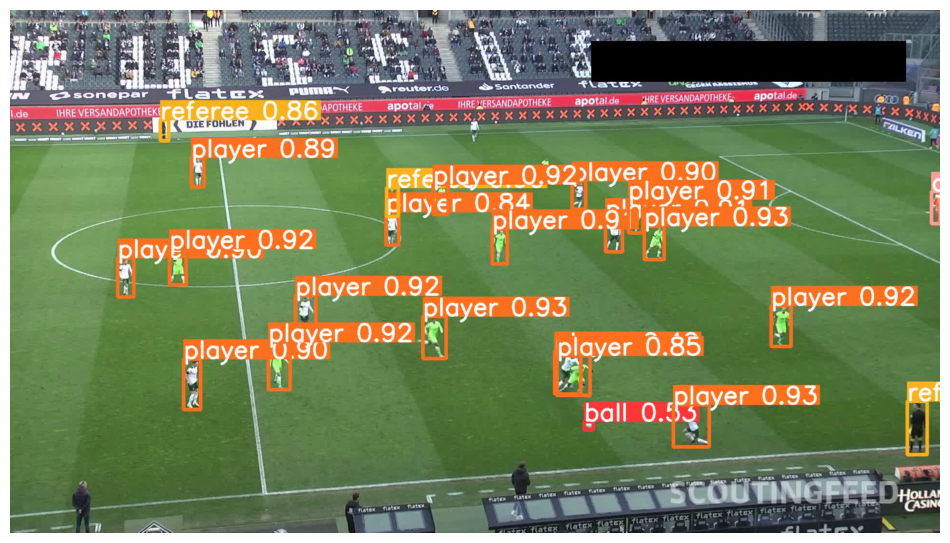

In [16]:
video_test_predict = os.path.join(ROOT_DIR, 'runs/detect/predict/08fd33_4(2).avi')
capture_frame(video_test_predict)


Já podemos observar uma diferença significativa em relação à predição anterior ao fine-tuning. Os objetos do jogo, que anteriormente eram classificados genericamente como 'person' e 'sports-ball', agora são mais precisamente identificados como 'player', 'referee', 'goalkeeper' e 'ball'. Este é apenas o primeiro passo, no entanto, ainda enfrentamos alguns desafios:

* **Limpeza:** A saída atual está poluída com bounding boxes e rótulos muito grandes. Para melhorar a visualização, pretendemos substituí-los por círculos posicionados sob os personagens.
* **Rastreamento de Objetos:** Além de identificar as classes, o verdadeiro valor deste MVP reside no rastreamento e identificação dos personagens (player_id).
* **Identificação de Equipes:** É crucial que possamos distinguir a qual equipe cada jogador pertence. Para isso, iremos identificá-los com base na cor de suas camisas.
* **Rastreamento da Bola:** O rastreamento preciso da bola é essencial para estimar a posse de bola de cada equipe. Como a bola é única, não precisamos atribuir a ela um 'ball_id'.
* **Desafio Extra:** Seria vantajoso aumentar a quantidade de amostras da bola no treinamento do modelo. Isso pode ser feito adicionando mais imagens com anotações correspondentes ou utilizando técnicas de data augmentation. Uma alternativa que exploraremos é a interpolação, que nos ajudará a manter o rastreamento da bola entre os frames. Essa técnica funciona bem quando há pequenos intervalos de ausência de detecção da bola, calculando sua trajetória entre os pontos detectados ao longo dos frames.

Vamos começar criando uma aba para as funçoes que utilizaremos para fazer leitura dos videos

#**4. Resolvendo os desafios**

##**4.1 Funções uteis**

Adicionamos duas funções essenciais para o processamento de vídeos em nosso projeto.

Essas funções serão essenciais para a leitura e processamento dos vídeos em nosso projeto, permitindo-nos manipular os frames individualmente e salvar as saídas geradas durante o processamento.

* **read_video**: Lê o vídeo fornecido como entrada. Ela recebe o caminho do vídeo como argumento, inicializa um array de frames vazio e itera através dos frames do vídeo. A cada iteração, o frame é lido e adicionado ao array de frames. Quando não houver mais frames para ler, a função retorna o array contendo todos os frames do vídeo.

* **save_video**: Salva uma sequência de frames como um novo vídeo. Ela recebe como entrada os frames que compõem o vídeo e o caminho onde o novo vídeo deve ser salvo. A função utiliza o codec XVID para a compressão do vídeo e escreve os frames no arquivo de vídeo de saída. Ao finalizar a escrita dos frames, o vídeo é salvo no caminho especificado.

In [17]:
def read_video(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = []
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(frame)
  return frames

def save_video(output_video_frames, output_video_path):
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(output_video_path, fourcc, 24, (output_video_frames[0].shape[1], output_video_frames[0].shape[0]))
  for frame in output_video_frames:
    out.write(frame)
  out.release()

* **get_center_of_bounding_box:** Esta função recebe as coordenadas de uma bounding box (caixa delimitadora) na forma (x1, y1, x2, y2) e calcula o ponto central da bounding box. Ela retorna as coordenadas (x, y) do centro da bounding box.
  
* **get_bounding_box_width:** Esta função recebe as coordenadas de uma bounding box na forma (x1, y1, x2, y2) e calcula a largura da bounding box. A largura é determinada pela diferença entre as coordenadas x do canto superior esquerdo e do canto superior direito da bounding box.
    
* **measure_distance:** Esta função recebe duas coordenadas de pontos (x1, y1) e (x2, y2) e calcula a distância euclidiana entre eles. A distância euclidiana é a medida da distância mais curta entre dois pontos em um espaço euclidiano.

In [18]:
def get_center_of_bounding_box(bounding_box):
  x1, y1, x2, y2 = bounding_box
  return int((x1 + x2) / 2), int((y1 + y2) / 2)

def get_bounding_box_width(bounding_box):
  return bounding_box[2] - bounding_box[0]

def measure_distance(point1, point2):
  return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5


## **4.2 Rastreamento de objetos**

Agora, nosso próximo desafio é implementar o rastreamento de objetos (tracking), pois até então, o modelo reconhece objetos em cada imagem individualmente, e estamos alimentando uma sequência de imagens (um vídeo), onde cada imagem é processada separadamente. Até agora, a detecção nos forneceu duas informações principais:

**1.  As coordenadas e o tamanho do objeto (xyxy)**

**2. A classe do objeto (player).**

No entanto, até o momento, não temos nenhuma informação que identifique exclusivamente um jogador. Seria interessante se pudéssemos determinar qual jogador e posição está presente no frame, e para onde vão nos frames seguintes. Para isso, precisamos implementar o rastreamento de objetos (tracking), analisando cada frame detectado pelo modelo. E para isso, optamos por utilizar o ByteTrack, ao inves da versão nativa do YOLO.

In [19]:
#Informando o modelo que iremos utilizar
model_path = YOLO(ROOT_DIR + '/models/best_new.pt')

Para uma análise eficiente de vídeos, desenvolvemos a classe Tracker, composta por sete funções essenciais:

* **interpolate_ball_positions:** Esta função utiliza a biblioteca Pandas para realizar a interpolação das posições da bola ao longo do tempo. É útil para suavizar o movimento da bola e preencher lacunas na detecção.
* **detect_frames:** Detecta objetos nos frames do vídeo em lotes de 20 frames. Isso ajuda a reduzir o tempo de processamento, melhorando a eficiência da detecção de objetos.
* **get_object_tracks:** Responsável por rastrear jogadores, árbitros e a bola usando o algoritmo ByteTrack Supervision. Esta função é computacionalmente intensiva e, portanto, os resultados são salvos em um arquivo pickle. Isso permite que o processo de rastreamento seja contornado à medida que o desenvolvimento do projeto avança, economizando tempo de processamento. Além disso, os goleiros são tratados como jogadores, e os resultados são armazenados em um conjunto de dicionários chamado tracks.
* **draw_ellipse:** Desenha uma elipse sob o jogador no frame do vídeo, usando a biblioteca OpenCV. Além disso, o ID do jogador é exibido para identificação.
* **draw_triangle:** Indica a posição da bola no frame do vídeo por meio de um triângulo. Isso fornece uma representação visual clara da localização da bola.
* **draw_team_ball_control:** Sinaliza a posse de bola de cada equipe durante o vídeo, calculando a distância entre o jogador e a bola em cada frame. Com base nisso, a porcentagem de posse de bola é determinada, informando a dinâmica do jogo.
* **draw_annotations:** Combina todas as informações processadas e as incorpora aos frames do vídeo. Isso inclui desenhos de elipses para jogadores, triângulos para a bola, indicadores de posse de bola e IDs de jogadores. Esses elementos fornecem uma análise visual abrangente do conteúdo do vídeo.

Essas funções trabalham em conjunto para fornecer uma análise detalhada e eficiente de vídeos, facilitando a compreensão dos eventos e dinâmicas presentes nas imagens em movimento.

In [20]:
class Tracker:
  def __init__(self, model_path):
    self.model = YOLO(model_path)
    self.tracker = sv.ByteTrack()


  def interpolate_ball_positions(self, ball_positions):
    ball_positions = [x.get(1, {}).get('bounding_box', []) for x in ball_positions]
    df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

    #interpolando valores ausentes
    df_ball_positions = df_ball_positions.interpolate()
    df_ball_positions = df_ball_positions.bfill() #caso a posiçao 1 seja vazia, nao tenha sido detectada

    #transformando para o formato original
    ball_positions = [{1: {'bounding_box': x}} for x in df_ball_positions.to_numpy().tolist()]

    return ball_positions


  def detect_frames(self, frames):
    batch_size = 20
    detections = []

    for i in range(0, len(frames), batch_size):
      detections_batch = self.model.predict(frames[i:i+batch_size], conf=0.1)
      detections += detections_batch
    return detections


  def get_object_tracks(self, frames, read_from_stub=False, stub_path=None):

    if read_from_stub and stub_path is not None and os.path.exists(stub_path):
      with open(stub_path, 'rb') as f:
        tracks = pickle.load(f)
      return tracks

    detections = self.detect_frames(frames)

    tracks = {
        'players': [],
        'referees': [],
        'ball': []
    }

    for frame_num, detection in enumerate(detections):
      classes_names = detection.names
      classes_names_reverse = { value:key for key, value in classes_names.items() }

      #Convertendo para Supervision Detection format
      detection_supervision = sv.Detections.from_ultralytics(detection)

      # reescrevendo o goalkeeper como player
      for object_index, class_id in enumerate(detection_supervision.class_id):
        if classes_names[class_id] == 'goalkeeper':
          detection_supervision.class_id[object_index] = classes_names_reverse['player']

      #Track objects
      detection_with_tracks = self.tracker.update_with_detections(detection_supervision)

      tracks['players'].append({})
      tracks['referees'].append({})
      tracks['ball'].append({})

      for frame_detection in detection_with_tracks:
        bounding_box = frame_detection[0].tolist()
        class_id = frame_detection[3]
        track_id = frame_detection[4]
        #obs: a bola é apenas uma, então nao precisamos rastrea-la

        if class_id == classes_names_reverse['player']:
          tracks['players'][frame_num][track_id] = { 'bounding_box': bounding_box }

        if class_id == classes_names_reverse['referee']:
          tracks['referees'][frame_num][track_id] = { 'bounding_box': bounding_box }

        for frame_detection in detection_with_tracks:
          bounding_box = frame_detection[0].tolist()
          class_id = frame_detection[3]

          if class_id == classes_names_reverse['ball']:
            tracks['ball'][frame_num][1] = { 'bounding_box': bounding_box } #Como a bola nao sera rastreada, passamos o valor [1] direto

    if stub_path is not None:
      with open(stub_path, 'wb') as f:
        pickle.dump(tracks, f)

    return tracks
    #vamos salvar esse objeto 'tracks'como um arquivo pickle, que dai podemos apenas le-lo, ao inves de rodar o codigo inteiro novamente
    # para isso, adicionaremos read_from_stub=False, stub_path=None na chamada da funcao get_object_tracks


  #Função para desenhar uma elipse sob os personagens
  def draw_ellipse(self, frame, bounding_box, color, track_id=None):
    y2 = int(bounding_box[3])  #y2 -> bottom
    x_center, _ = get_center_of_bounding_box(bounding_box)
    width = get_bounding_box_width(bounding_box)

    cv2.ellipse(
        frame,
        center = (x_center, y2),
        axes = (int(width), int(0.35*width)),
        angle = 0.0,
        startAngle = -45,  #iniciando em -45 e finalizando em 235, o circulo nao irá cobrir o jogador
        endAngle = 235,    # portanto nao utilizaremos uma elipse completa, para que nao se sobreponha aos personagens
        color = color,
        thickness = 2,
        lineType = cv2.LINE_4
    )

    #Configurações para Retangulo abaixo de cada player, informando seu track_id
    rectangle_width = 40
    rectangle_height = 20
    x1_rectangle = int(x_center - rectangle_width // 2)
    x2_rectangle = int(x_center + rectangle_width // 2)
    y1_rectangle = int(( y2 - rectangle_height // 2 ) + 15)
    y2_rectangle = int(( y2 + rectangle_height // 2 ) + 15)

    if track_id is not None:
      cv2.rectangle(
                      frame,
                      (x1_rectangle, y1_rectangle),
                      (x2_rectangle, y2_rectangle),
                      color,
                      cv2.FILLED
                    )

      #Inserindo o texto dentro do retangulo, de acordo com o tamanho do track_id
      x1_text = x1_rectangle + 12
      if track_id > 99:
        x1_text -= 10

      cv2.putText(
                  frame,
                  f'{track_id}',
                  (int(x1_text), y1_rectangle + 15),
                  cv2.FONT_HERSHEY_SIMPLEX,
                  0.6,
                  (0, 0, 0),
                  2
                )

    return frame


  #desenhando o triangulo/indicador da bola
  def draw_triangle(self, frame, bounding_box, color):
    y = int(bounding_box[1])
    x, _ = get_center_of_bounding_box(bounding_box)

    triangle_points = np.array([
        [x, y],
        [x - 10, y - 20],
        [x + 10, y - 20]
    ])
    cv2.drawContours(frame, [triangle_points], 0, color, cv2.FILLED)
    cv2.drawContours(frame, [triangle_points], 0, (0, 0, 0), 2)

    return frame


  #Desenhando o quadro de posse de bola
  def draw_team_ball_control(self, frame, frame_num, team_ball_control):
    #Plotar um retangulo translucido
    overlay = frame.copy()
    cv2.rectangle(overlay, (1350, 850), (1900, 970), (255, 255, 255), -1)
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    team_ball_control_till_frame = team_ball_control[:frame_num + 1]

    #calcular o numero de vezes que cada time possuir o controle da bola
    team_1_num_frames = team_ball_control_till_frame[team_ball_control_till_frame == 1].shape[0]
    team_2_num_frames = team_ball_control_till_frame[team_ball_control_till_frame == 2].shape[0]

    #Estatisticas
    team_1 = team_1_num_frames/(team_1_num_frames + team_2_num_frames)
    team_2 = team_2_num_frames/(team_1_num_frames + team_2_num_frames)

    #Plotar os textos informando a posse de bola de ambos os times
    cv2.putText(
                frame,
                f'Team 1 Ball Control: {team_1*100:.2f}',
                (1400, 900),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 0),
                3
              )

    cv2.putText(
            frame,
            f'Team 2 Ball Control: {team_2*100:.2f}',
            (1400, 950),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 0),
            3
          )

    return frame


  #Desenhando as anotacoes
  def draw_annotations(self, video_frames, tracks, team_ball_control):
    output_video_frames = []
    for frame_num, frame in enumerate(video_frames):
      frame = frame.copy()

      player_dict = tracks['players'][frame_num]
      referee_dict = tracks['referees'][frame_num]
      ball_dict = tracks['ball'][frame_num]

      #plotando a elipse sob os jogadores (players)
      for track_id, player in player_dict.items():
        color = player.get('team_color', (255, 0, 0))
        frame = self.draw_ellipse(frame, player['bounding_box'], color, track_id)

        if player.get('has_ball', False):
          frame = self.draw_triangle(frame, player['bounding_box'], color)

      #plotando a elipse sob os Arbitros (referee)
      for _, referee in referee_dict.items():
        frame = self.draw_ellipse(frame, referee['bounding_box'], (0, 0, 0))

      #plotando o triangulo sobre a bola (ball)
      for track_id, ball in ball_dict.items():
        frame = self.draw_triangle(frame, ball['bounding_box'], (0, 255, 0))

      #plotando a posse de bola
      frame = self.draw_team_ball_control(frame, frame_num, team_ball_control)

      output_video_frames.append(frame)

    return output_video_frames


Uma observação sobre o formato do dicionário gerado acima


    # Como esperamos esse dado? uma lista de dicionários

     'players':[
                 {                              # -> esse objeto representa 1 unico frame
                  0:{'bounding_box': [0,0,0,0]},
                  1:{'bounding_box': [0,0,0,0]},
                  2:{'bounding_box': [0,0,0,0]},
                 },
                 {                             # -> esse objeto representa 1 unico frame
                  0:{'bounding_box': [0,0,0,0]},
                  1:{'bounding_box': [0,0,0,0]},
                  2:{'bounding_box': [0,0,0,0]},
                 },
                ]

##**4.3  Definindo o time dos jogadores**


Nesta seção vamos abordar como definimos as equipes dos jogadores detectados. Para isso, foi desenvolbidouma série de funções que utilizam técnicas de processamento de imagens e aprendizado não supervisionado. Vamos dar uma olhada em cada uma dessas funções e entender como elas contribuem para atribuir as cores e, consequentemente, os times aos jogadores.

* **get_clustering_model:**
Cria e treina um modelo de clustering (KMeans) para agrupar cores de pixels em uma imagem em dois clusters.
* **get_player_color:**
Define a cor predominante de um jogador em um frame do vídeo, utilizando o modelo de clustering que treinamos na função anterior.
* **assign_team_color:**
Atribue cores às equipes com base nas cores dos jogadores detectados no frame de vídeo, utilizando o algoritmo KMeans para agrupar as cores.
* **get_player_team:**
Identificaa equipe à qual um jogador pertence com base na cor predominante do jogador, utilizando o modelo de clustering treinado na primeira função.

In [21]:
class TeamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.player_team_dict = {}  #team 1 ou team 2

    def get_clustering_model(self, image):
        #Transformar imagem num array 2d
        image_2d = image.reshape(-1,3)

        #Instanciando o Kmenas com 2 clusters
        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=1)
        kmeans.fit(image_2d)

        return kmeans


    def get_player_color(self, frame, bounding_box):
        image = frame[int(bounding_box[1]):int(bounding_box[3]),int(bounding_box[0]):int(bounding_box[2])]

        top_half_image = image[0:int(image.shape[0]/2),:]

        #Utilizando o modelo clusterizado
        kmeans = self.get_clustering_model(top_half_image)

        # Capturando os labels de cada pixel
        labels = kmeans.labels_

        # transformando os labels no formato da imagem
        clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

        # Definindo a cor do cluster que representa o jogador
        corner_clusters = [clustered_image[0,0],clustered_image[0,-1],clustered_image[-1,0],clustered_image[-1,-1]]
        non_player_cluster = max(set(corner_clusters),key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color


    def assign_team_color(self,frame, player_detections):

        player_colors = []
        for _, player_detection in player_detections.items():
            bounding_box = player_detection["bounding_box"]
            player_color =  self.get_player_color(frame,bounding_box)
            player_colors.append(player_color)

        #Separando as cores de cada time
        kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10)
        kmeans.fit(player_colors)

        #salvando o kmeans dentro de self, para que possamos usar novamente
        self.kmeans = kmeans

        #definindo as cores aos times
        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]


    def get_player_team(self,frame,player_bounding_box,player_id):
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        player_color = self.get_player_color(frame,player_bounding_box)

        #utilizando o modelo do kmeans que salvamos anteriormente
        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id+=1

        if player_id == 91 :
           team_id = 1

        #salvando o player_id e o team_id
        self.player_team_dict[player_id] = team_id

        return team_id

##**4.4 Definindo o portador da bola**


Nesta nova seção, vamos explorar o processo de atribuição do portador da bola entre os jogadores detectados no vídeo. É uma parte crucial da análise, pois nos permite identificar qual jogador está atualmente controlando a bola durante o jogo.


A função **assign_ball_to_player**  determina qual jogador está mais próximo da posição atual da bola com base em suas coordenadas de detecção. Calculando a distância entre a posição da bola e os pés esquerdo e direito de cada jogador. O jogador mais próximo da bola, dentro de uma distância máxima pré-definida, é então designado como o portador da bola.

In [22]:
class PlayerBallAssigner():
  def __init__(self):
    self.max_player_ball_distance = 70

  def assign_ball_to_player(self, players, ball_bounding_box):
    ball_position = get_center_of_bounding_box(ball_bounding_box)

    min_distance = 99999
    assigned_player = -1

    for player_id, player in players.items():
      player_bounding_box = player['bounding_box']

      distance_left_foot = measure_distance((player_bounding_box[0], player_bounding_box[-1]), ball_position)
      distance_right_foot = measure_distance((player_bounding_box[2], player_bounding_box[-1]), ball_position)
      distance = min(distance_left_foot, distance_right_foot)

      if distance < self.max_player_ball_distance:
        if distance < min_distance:
          min_distance = distance
          assigned_player = player_id

    return assigned_player




#**5. Simulação da Solução**

Nesta seção, realizaremos a simulação de uma solução para rastreamento e análise de vídeo de uma partida de futebol. O objetivo é aplicar todas as funcionalidades desenvolvidas anteriormente, desde a detecção e rastreamento de objetos até a visualização das informações relevantes no vídeo resultante.

O processo será dividido em etapas, cada uma com um conjunto específico de códigos e funções:

* **Leitura do Vídeo:** Faremos a leitura do vídeo de entrada que contém a partida de futebol a ser analisada.

* **Inicialização do Tracker:** Utilizaremos a classe Tracker para inicializar o modelo de detecção de objetos, essencial para identificar e rastrear jogadores, árbitros e a bola ao longo do vídeo.

* **Rastreamento de Objetos:** Faremos o rastreamento dos objetos no vídeo, identificando suas posições e movimentos em cada frame.

* **Interpolação da Posição da Bola:** Realizaremos a interpolação das posições da bola para garantir uma representação suave do seu movimento, mesmo em frames onde não foi detectada.

* **Definição dos Times dos Jogadores:** Atribuiremos cores distintas aos times dos jogadores com base na cor de suas camisetas, utilizando a classe TeamAssigner.

* **Determinação da Posse de Bola:** Analisaremos as posições dos jogadores em relação à bola para determinar qual jogador está com a posse dela em cada momento do vídeo.

* **Desenho das Anotações no Vídeo:** Aplicaremos todas as anotações visuais, como elipses sobre os jogadores, triângulos sobre a bola e estatísticas de posse de bola, aos frames do vídeo resultante.

* **Salvando do Vídeo de Saída:** Por fim, salvaremos o vídeo resultante com todas as anotações visuais aplicadas, pronto para análise e visualização.


In [23]:
# Leitura do Vídeo
video_frames = read_video(ROOT_DIR + '/input_videos/08fd33_4.mp4')

# Inicialização do Tracker
tracker = Tracker(ROOT_DIR + '/models/best_new.pt')

tracks = tracker.get_object_tracks(video_frames,
                                   read_from_stub=True,
                                   stub_path=ROOT_DIR + '/stubs/track_stubs2.pkl')


# Interpolação da Posição da Bola
tracks['ball'] = tracker.interpolate_ball_positions(tracks['ball'])

# Definindo os jogadores e seus times
team_assigner = TeamAssigner()
team_assigner.assign_team_color(video_frames[0], tracks['players'][0])

# Percorrer cada jogador e definir seu time, baseado na cor da camisa.
for frame_num, player_track in enumerate(tracks['players']):
  for player_id, track in player_track.items():
    team = team_assigner.get_player_team(video_frames[frame_num], track['bounding_box'], player_id)
    tracks['players'][frame_num][player_id]['team'] = team
    tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]


# Determinando posse de bola
player_assigner = PlayerBallAssigner()
team_ball_control = []

for frame_num, player_track in enumerate(tracks['players']):
  ball_bounding_box = tracks['ball'][frame_num][1]['bounding_box']
  assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bounding_box)

  if assigned_player != -1:
    tracks['players'][frame_num][assigned_player]['has_ball'] = True
    team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
  else:
    team_ball_control.append(team_ball_control[-1])

# Converter para numpy array para conseguir trabalhar com esses dados e calcular a posse de bola
# Assim o dado fica preparado para ser utilizado na funcao draw_team_ball_control na classe Tracker
team_ball_control = np.array(team_ball_control)

# Desenho das Anotações no Vídeo
output_video_frames = tracker.draw_annotations(video_frames, tracks, team_ball_control)


# Salvando o video
save_video(output_video_frames, ROOT_DIR + '/output_videos/08fd33_4.avi')


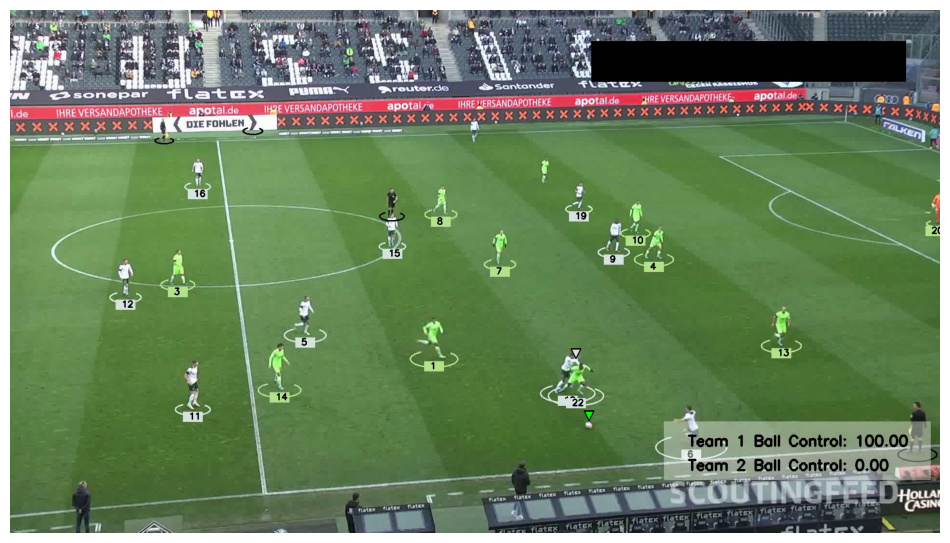

In [25]:
final_video = os.path.join(ROOT_DIR, 'output_videos/08fd33_4.avi')
capture_frame(final_video)

#**6. Extra**

Nesta seção, vamos elucidar o processo de utilização do algoritmo de clustering K-Means para identificar e atribuir cores às camisas dos atletas. Que irá nos apoiar no agrupamento de dados não rotulados. Neste caso, utilizaremos para discernir as cores das camisas dos jogadores.

Para isso, precisamos da imagem de um jogador, então vamos utilizar algumas funções criadas anterioremente que identifica um jogador, e cortar a imagem com as coordenadas do bounding box.

In [26]:
#Salvando um corte da imagem representando um player
for track_id, player in tracks['players'][0].items():
  bounding_box = player['bounding_box']
  frame = video_frames[0]

  #Cortando o bounding box do frame
  cropped_image = frame[int(bounding_box[1]):int(bounding_box[3]), int(bounding_box[0]):int(bounding_box[2])]

  # salvando a imagem cortada
  cv2.imwrite((ROOT_DIR + '/output_videos/cropped_image.jpg'), cropped_image)
  break

Aqui estamos plotando a imagem recortada, e convertendo as cores para RGB.

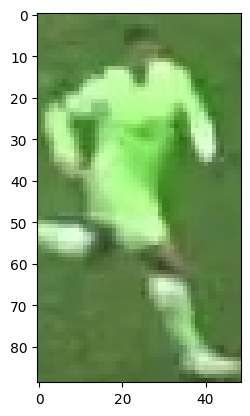

In [27]:
image_path = ROOT_DIR + '/output_videos/cropped_image.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

É consenso que a parte superior do bounding box corresponde à região da camisa do jogador em jogo. Portanto, vamos dividir a imagem ao meio e utilizar apenas essa porção superior para análise.

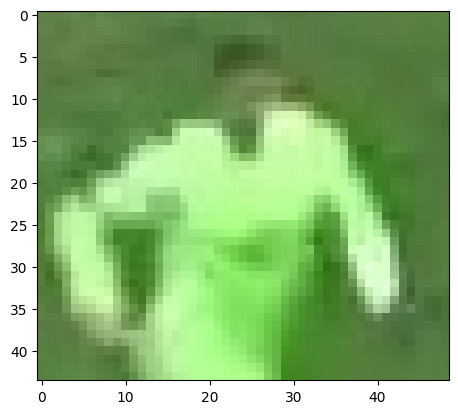

In [28]:
top_half_image = image[0: int(image.shape[0] / 2), :]
plt.imshow(top_half_image)

Certo, agora vamos extrair a cor predominante nessa região da imagem. No entanto, surge um problema: a cor de fundo será mais abundante do que a cor da camisa do jogador. Portanto, precisamos segmentar essa imagem ou remover o fundo de alguma maneira. Vamos dividir a imagem em dois grupos (clusters).

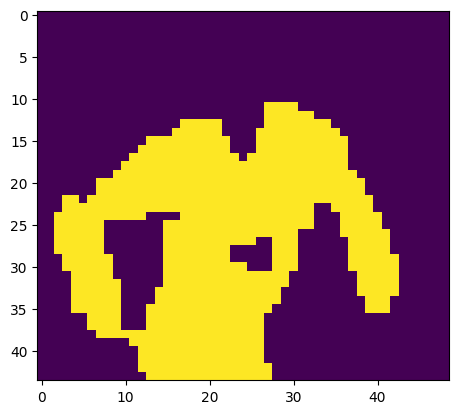

In [29]:
# primeiro vamos transforma-la em um array 2d
top_half_image_2d = top_half_image.reshape((-1, 3))

# Agora vamos aplicar o KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(top_half_image_2d)

# Capturar os labels do cluster
labels = kmeans.labels_

#remontar os labels no formato original da imagem
clustered_top_half_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

#visualizando o resultado
plt.imshow(clustered_top_half_image)

E como vamos distinguir o que o algoritmo K-means classificou como 0 ou 1?

Para isso, vamos usar os valores dos vértices da imagem, que na maioria das vezes serão preenchidos com a cor de fundo.

In [30]:
corner_clusters =[clustered_top_half_image[0, 0],
                  clustered_top_half_image[0, -1],
                  clustered_top_half_image[-1, 0],
                  clustered_top_half_image[-1, -1]]

non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)

print(non_player_cluster)

0


In [31]:
#entao, basta somarmos 1 ao valor, para obtermos o valor do player
player_cluster = non_player_cluster + 1

print(player_cluster)

1


In [32]:
kmeans.cluster_centers_[player_cluster]

array([     171.38,      235.65,      142.85])

#**Conclusão**

Ao longo deste MVP, desenvolvemos um sistema de análise de vídeo para rastreamento de objetos. Utilizando técnicas de visão computacional e aprendizado de máquina, conseguimos identificar e acompanhar jogadores, árbitros e a bola em tempo real durante uma partida de futebol.

Por meio da integração do modelo YOLO para detecção de objetos e a aplicação do algoritmo K-means para segmentação de cores, conseguimos atribuir cores de camisa aos jogadores, facilitando a identificação de suas equipes. Além disso, implementamos métodos para determinar a posse de bola com base na proximidade dos jogadores ao objeto em movimento.

O sistema demonstrou sua capacidade de produzir resultados visualmente informativos, oferecendo uma perspectiva valiosa sobre o desempenho das equipes e a dinâmica do jogo. No entanto, há diversas oportunidades para melhorias e expansões futuras.

Além disso, podemos de enriquecer a base de dados com imagens de jogos brasileiros, considerando as peculiaridades climáticas e de iluminação distintas, como partidas realizadas durante o dia com variações de luminosidade devido à sombra ou à incidência direta do sol. A aplicação de técnicas de data augmentation também pode contribuir para a robustez do sistema, permitindo uma maior diversidade de cenários e condições de jogo.

Outra área promissora de desenvolvimento é a implementação do reconhecimento dos números das camisas dos jogadores, similar ao exemplo apresentado em aula, para uma identificação mais precisa e individualizada dos atletas. Esses dados podem ser associados às estatísticas das partidas, fornecendo insights adicionais sobre o desempenho de cada jogador ao longo do jogo e ao longo da temporada.

Além disso, a utilização de keypoints para mapear o campo e acompanhar o posicionamento dos jogadores em tempo real, proporcionando uma representação visual em um mini quadro tático, pode agregar uma nova camada de análise e compreensão tática do jogo, similar às interfaces de videogames.

Essas são apenas algumas das muitas ideias de aprimoramento e expansão que podem ser exploradas neste projeto, destacando seu potencial para evoluir e se adaptar às demandas e oportunidades em constante mudança no cenário esportivo.

Em suma, este projeto demonstra o potencial das tecnologias de visão computacional e aprendizado de máquina na análise de eventos esportivos, oferecendo uma base para futuras pesquisas e desenvolvimentos nessa área.